<a href="https://colab.research.google.com/github/mostafa-metwaly/ComputerVision_PlateRecognition/blob/main/Mostafa_Metwally_Plate_recognition_Hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plate recognition (HW)
![alt text](https://i.ytimg.com/vi/nmDiZGx5mqU/hqdefault.jpg)

**Deadline:** February 4 23:55<br>
**Submission format:** .ipynb file with solution

Automatic License Plate Recognition (ALPR) systems are commonly used in many countries. In this homework you will try to recognize a Russian license (number) plate. You can use any method for symbol recognition (some classic algorithm, CNN  or Tesseract). But you are not allowed to use Tesseract for full number plate recognition, only use it to recognize single symbols! The main concept is:


1. Undistort the plate (you are given 4 corner points of the plate)
2. Perform segmentation
3. Recognize symbols
4. Concatenate recognized symbols

**Very important**: Your code needs to run! Hand in all files that are needed to run the code within a .zip-file and instructions to make it run! **Not running code parts will be awarded 0 points.**

**Plagiarism**, meaning identical code as in a different submission will lead to **0 points** for the whole submission! What is allowed is that you copy code if you use an existing model for recognizing the symbols - remember to reference the source from where you got the code!

### Preparations

In [1]:
# Import libraries
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
# set inline plots size
plt.rcParams["figure.figsize"] = (30, 14) # (w, h)
import numpy as np
import cv2
!sudo apt install tesseract-ocr
!pip install pytesseract
from IPython.display import clear_output
import pytesseract
from pytesseract import Output
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
clear_output()
# some refrences and instructions for using the tesseract library
# https://github.com/tesseract-ocr/tesseract
# https://nanonets.com/blog/ocr-with-tesseract/#gettingboxesaroundtext


# Github: "https://github.com/mostafa-metwaly/ComputerVision_PlateRecognition"

##Input##
Sample input image is aupplied.

In [2]:
!wget "https://docs.google.com/uc?export=download&id=1XGLQv0ggS5uFPMOcyu7xyDEMIiSV8pQM" -O yandexcar2.jpg
!wget "https://docs.google.com/uc?export=download&id=1G2b9-v8mFL9ynvnIbExQUKAz4Ivtxwde" -O yandexcar4.jpg
from google.colab.patches import cv2_imshow
clear_output()


In [3]:

# Read Image, little preprocessing
def read_and_resize(filename, grayscale = False, fx= 1, fy=1):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      # convert to rgb
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    # resize
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result
 
    
def showInRow(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    # set inline plots size
    plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

    # function for colors array generation
def generate_colors(num):
  r = lambda: np.random.randint(0,255)
  return [(r(),r(),r()) for _ in range(num)] 


In [4]:

# Image coordinates of the extermities of plates
plate_points_1 = np.array([[262,1960], [520,1965], [518,2032], [262, 2028]], np.int32) # plate yandex car
# I used drawing programs like photoshop and paint to detect the corners of the plate coordinates
plate_points_2 = np.array([[609,400],[651,382],[651,403],[609,424]]) # manually determine coordinates in case other images are used

RUS_points_box = np.array([[712,181],[917,181],[917,248],[712,248]], np.int32) # plate yandex car


## Task 1: Draw borders around the number plate (10 points)

*   List item
*   List item



Draw the borders around the number plate and display the image with borders to visualize the region of interest! Try to get the tetragonal area as accurate as possible using the given plate points above! Also try to display colored borders on the otherwise greyscale image! Remember to draw on a copy of the image to leave the original image clean for the processing.

In [5]:

def process_img(img,plate_points,line_width = 20):
  
    # A copied image of the original
    yandexcar2_gray = img.copy()
    # Converting into a grey image
    yandexcar2_gray  = cv2.cvtColor(yandexcar2_gray,cv2.COLOR_RGB2GRAY)

    # Detecting the outer contour of the number plate polygon
    yandexcar2_gray1 = yandexcar2_gray.copy()
    # For Polygon:
    plate_points_2 = plate_points.reshape((-1,1,2))
    print(plate_points_2.shape)
    # image, polygon lines, closed , color red , line thickness
    yandexcar2_poly = cv2.polylines(yandexcar2_gray1,[plate_points_2],True,(255,0,0),line_width)

    return yandexcar2_gray , yandexcar2_gray1  , yandexcar2_poly



## Task 2: Undistort the plate (20 points)

Undistort the plate, so you receive an image that contains only the number plate. The OpenCV functions ```findHomography``` and ```warpPerspective``` might be helpful to get to the expected result!

Expected result:

![alt text](https://docs.google.com/uc?export=download&id=1EjIacTJUxPwRU5bYEG2EV_HbINHl9bem)

In [6]:
def Undistort_image(img,img_gray,plate_points,Box_points,y=925,x=228):
    yandexcar2 = img.copy()
    img_gray = img_gray.copy()
    # cropping image using mask and bounding rectangle points
    poly = cv2.boundingRect(plate_points) # returns (x,y,w,h) of the poly
    yandexcar2_gray2_cropped = yandexcar2[poly[1]: poly[1] + poly[3], poly[0]: poly[0] + poly[2]]


 

    pts1 = np.float32([[0,0],[y,0],[y,x],[0,x]])
    M = cv2.getPerspectiveTransform(np.float32(plate_points),pts1)
    output = cv2.warpPerspective(yandexcar2,M,(y,x))
    output_gray = cv2.warpPerspective(img_gray,M,(y,x))

    yandexcar_process = cv2.medianBlur(output_gray,13)

    ret,thresh3 = cv2.threshold(yandexcar_process,150,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    Box_points2 = Box_points.reshape((-1,1,2))
    thresh4 = 255 - thresh3
    ret, thresh = cv2.threshold(thresh4, 248, 255, cv2.THRESH_BINARY)
    box = cv2.fillPoly(thresh,[Box_points2],(0,0,0))
    thresh[(thresh.shape[0]-30):30,:] = 0 #using the data from a selected region only
    thresh5 = 255 - thresh
    yandexcar_process = cv2.medianBlur(thresh5,13)

    # erosion
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(yandexcar_process,kernel,iterations =2)
    # dilation
    kernel = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(erosion,kernel,iterations = 2)
    yandexcar_process = dilation



    return output ,output_gray, yandexcar2_gray2_cropped ,dilation ,yandexcar_process



## Task 3: Segmentation (20 points)
Segment the symbols so that you can draw bounding rectangles around them. For example, you can use morphological operations, ```findContours```, and ```minAreaRect```. Draw only rectangles around the symbols that are relevant for recognition!


Expected result:


In [7]:
def Segmentation(yandexcar_process,output):
    yandex_gray = yandexcar_process.copy()
    thresh = 255-yandex_gray

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    im2 = cv2.drawContours(thresh, contours, -1, (255, 0, 0))
    img_contours=output.copy()

    print('Contours type is: {}'.format(type(contours)))
    print('Number of contours: {}'.format(len(contours)))
    print('Each contour is: {}'.format(type(contours[0])))
    print('Contour array shape is: {}'.format(contours[0].shape))

    # draw contours on input image
    cv2.drawContours(img_contours, contours, -1, (255,0,0), 3)

    plt.subplot(131),plt.imshow(yandexcar_process,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(img_contours,cmap = 'gray')
    plt.title('Image with contours'), plt.xticks([]), plt.yticks([])
    plt.subplot(133),plt.imshow(im2,cmap = 'gray')
    plt.title('Threshold image with contours'), plt.xticks([]), plt.yticks([])
    
    plt.show()
    Plate_Symbols = yandexcar_process.copy()
    Plate_Symbols = 255-Plate_Symbols

    connectivity=4
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(Plate_Symbols, connectivity, cv2.CV_32S)

    print('Input image shape is {}'.format(Plate_Symbols.shape))
    print('Labels type is {}'.format(type(labels)))
    print('Labels shape is {}'.format(labels.shape))
    print('Number of labels is {}'.format(n_labels))
    print('Centroids coordinates \n {}'.format(centroids))
    # print('Statistics\n {}'.format(stats))
    colors = generate_colors(n_labels)
    labeled_image = np.zeros((Plate_Symbols.shape[0],Plate_Symbols.shape[1],3), dtype=np.uint8)
    labeled_image2 = np.zeros((Plate_Symbols.shape[0],Plate_Symbols.shape[1],3), dtype=np.uint8)


    x= 7
    rect = []
    shapes=[]
    shapess=[]
    # loop over all components and determine if it is a number
    for (i, label) in enumerate(range(1, n_labels)):
      if stats[label, cv2.CC_STAT_AREA] >= 3400:
        labeled_image[labels == label,:]= colors[i]
        labeled_image2[labels == label,:]= colors[i]
        # centroid coordinates
        cent_x, cent_y = int(centroids[label,0]), int(centroids[label,1])
        cv2.circle(labeled_image,(cent_x, cent_y), 3, (255,0,0), -1)
        rectang = cv2.rectangle(labeled_image,(stats[label, cv2.CC_STAT_LEFT]-x, stats[label, cv2.CC_STAT_TOP]-x) , (stats[label, cv2.CC_STAT_LEFT]+stats[label, cv2.CC_STAT_WIDTH]+x, stats[label, cv2.CC_STAT_TOP]+stats[label, cv2.CC_STAT_HEIGHT]+x) , (255,0,0),1)
        # cv2.fillpoly
        cv2.putText(labeled_image, str(i), (cent_x, cent_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1)
        rect.append(stats[label, cv2.CC_STAT_LEFT])
        shape = labeled_image2[stats[label, cv2.CC_STAT_TOP]-x : stats[label, cv2.CC_STAT_TOP]+stats[label, cv2.CC_STAT_HEIGHT]+x , stats[label, cv2.CC_STAT_LEFT]-x : +stats[label, cv2.CC_STAT_WIDTH]+stats[label, cv2.CC_STAT_LEFT]+x].copy()
        shapes.append(shape)

    print('leftmost coordinate {}'.format(stats[label, cv2.CC_STAT_LEFT]))
    print('top coordinate {}'.format(stats[label, cv2.CC_STAT_TOP ]))
    print('cc width {}'.format(stats[label, cv2.CC_STAT_WIDTH]))
    print('cc height {}'.format(stats[label, cv2.CC_STAT_HEIGHT ]))
    print('Input image shape is {}'.format(Plate_Symbols.shape))
    print('Labels type is {}'.format(type(labels)))
    print('Labels shape is {}'.format(labels.shape))
    print('Centroids coordinates \n {}'.format(centroids))
    
    plt.title('colored labels')
    plt.xticks([]),plt.yticks([])
    plt.imshow(labeled_image2)
    plt.imshow(labeled_image2)
    plt.show() 
    plateNo2 =labeled_image2

    cv2.imwrite('plateNo2.jpg',plateNo2)
    
    return shapes , plateNo2

## Task 4: Recognition (30 points)

Use any method/library to recognize the letters, of which you found the image regions in the previous step.

PS: If you arey not using out of the box methods like tesseract you may try conventional classifiers like SVM. Apart from this deep learning techniques are also another option. For e.g., a CNN can help you to recognize letters. You can use any CNN model that you find on the internet, or even train your own. The EMNIST (Extended MNIST) dataset may be helpful. Remember to include files/instructions into the submission!

Symbols ```O``` and ```0``` are hard to distinct and will lead to no point reduction. Also ```1``` and ```7``` might be harder to distinguish and will only lead to a small reduction of points.


Expected result:

![alt text](https://docs.google.com/uc?export=download&id=1rYg7Cs8D7TMMu0ElAmSoEQOZeECkTvj7)


In [8]:
def pytesseract_image_recognition(yandexcar_process,shapes):

      # for Custom Configuration :
      # -l lenguage to be detected , blacklisting symbols and other 
      # Page segmentation modes --psm  , OCR Engine modes --oem
      extractedInformation =[]
      custom_config = r'-l eng -c tessedit_char_blacklist=: --oem 3 --psm 6 '
    
      for idx in range(len(shapes)):          
        extractedInformation1 = pytesseract.image_to_string(shapes[idx], output_type=Output.DICT)
          # print(extractedInformation1)
          # extractedInformation.append(extractedInformation1)
          # showInRow([shapes[idx]])
 
          

      print('######################################')
      print(pytesseract.image_to_boxes(shapes[idx]))
      print('######################################')
      print(extractedInformation1.keys())

## Task 5: Concatenation (5 points)
This should be the easiest part if you have done all previous steps:) Remember to get the order of symbols right!

Expected result: 


(4, 1, 2)


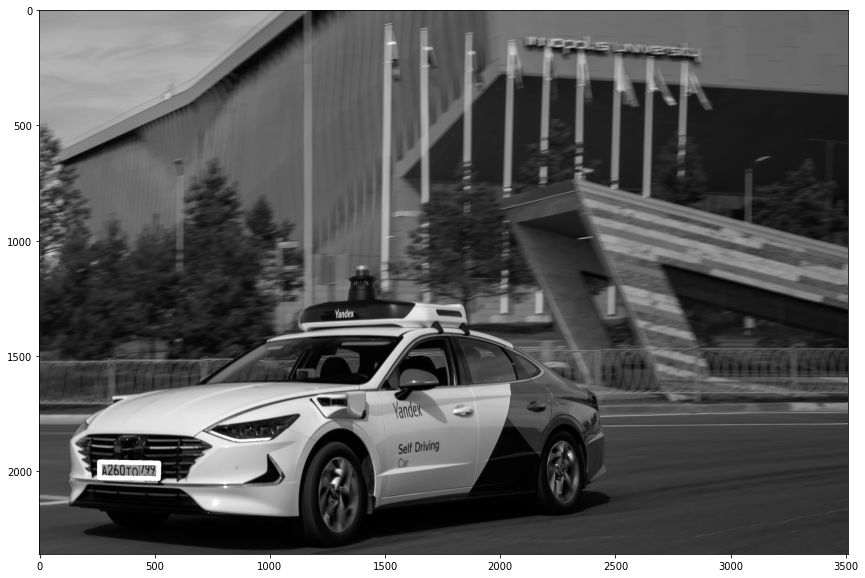

(4, 1, 2)


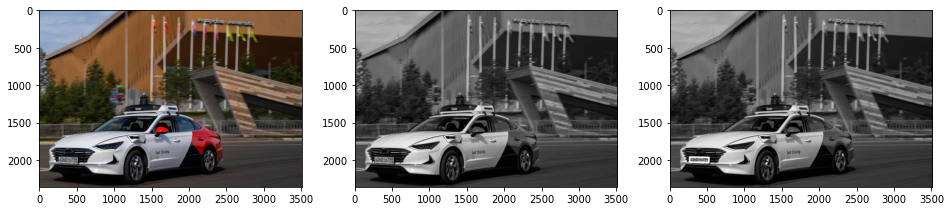

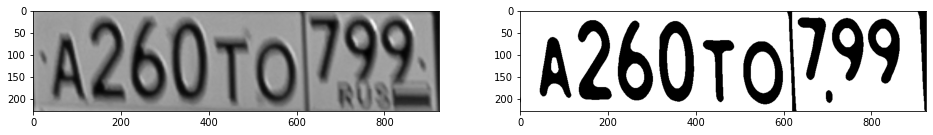

Contours type is: <class 'list'>
Number of contours: 19
Each contour is: <class 'numpy.ndarray'>
Contour array shape is: (6, 1, 2)


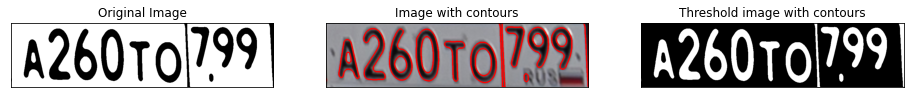

Input image shape is (228, 925)
Labels type is <class 'numpy.ndarray'>
Labels shape is (228, 925)
Number of labels is 14
Centroids coordinates 
 [[4.61865201e+02 1.14033908e+02]
 [6.19522523e+02 1.13809122e+02]
 [9.18877798e+02 8.86647269e+01]
 [6.69755407e+02 7.13516689e+01]
 [7.50576172e+02 7.96203125e+01]
 [8.33106985e+02 8.24225515e+01]
 [1.69881242e+02 1.18977058e+02]
 [2.58091727e+02 1.26957329e+02]
 [3.56092700e+02 1.16518249e+02]
 [7.72279531e+01 1.33503236e+02]
 [4.52747897e+02 1.16628953e+02]
 [5.53441996e+02 1.42161576e+02]
 [7.03867232e+02 1.94841808e+02]
 [3.68421053e-01 2.02684211e+02]]
leftmost coordinate 0
top coordinate 197
cc width 2
cc height 12
Input image shape is (228, 925)
Labels type is <class 'numpy.ndarray'>
Labels shape is (228, 925)
Centroids coordinates 
 [[4.61865201e+02 1.14033908e+02]
 [6.19522523e+02 1.13809122e+02]
 [9.18877798e+02 8.86647269e+01]
 [6.69755407e+02 7.13516689e+01]
 [7.50576172e+02 7.96203125e+01]
 [8.33106985e+02 8.24225515e+01]
 [1.698

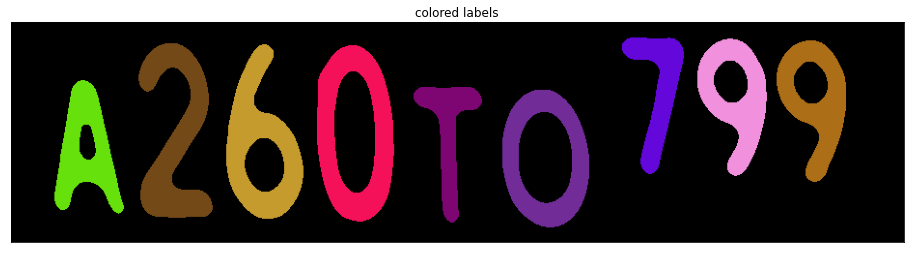

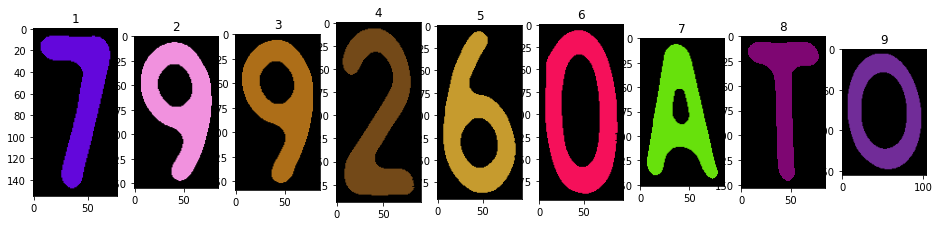

######################################

######################################
dict_keys(['text'])


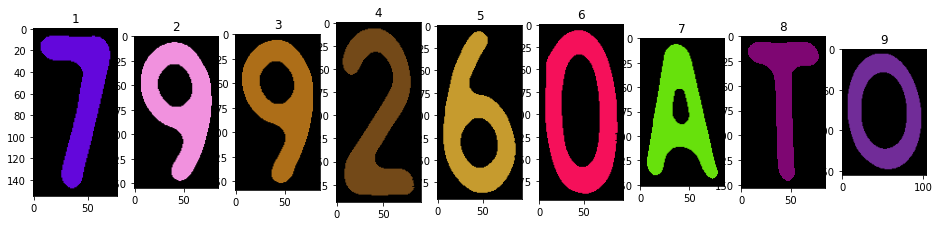

In [9]:
def Testing_code(validate=False,img_name = 'yandexcar4'):
    yandexcar4 = img_name
    # Task1
    if validate == True:
        yandexcar4 = read_and_resize('yandexcar4.jpg')
        yandexcar2_gray ,yandexcar2_poly , yandexcar2_gray1 = process_img(yandexcar4,plate_points_2)
    else:
        yandexcar2 = read_and_resize('yandexcar2.jpg')
        yandexcar2_gray ,yandexcar2_poly , yandexcar2_gray1 = process_img(yandexcar2,plate_points_1)
    showInRow([yandexcar2_poly])

    # Task2
    # Showing the pictures in row
    if validate == True:
        yandexcar4 = read_and_resize('yandexcar4.jpg')
        yandexcar2_gray ,yandexcar2_poly , yandexcar2_gray1 = process_img(yandexcar4,plate_points_2)
        showInRow([yandexcar2,yandexcar2_gray,yandexcar2_poly])
    else:
        yandexcar2 = read_and_resize('yandexcar2.jpg')
        yandexcar2_gray ,yandexcar2_poly , yandexcar2_gray1 = process_img(yandexcar2,plate_points_1)
        showInRow([yandexcar2,yandexcar2_gray,yandexcar2_poly])


    # Task3
    # show output 
    if validate == True:
       output , output_gray,yandexcar2_gray2_cropped,dilation ,yandexcar_process = Undistort_image(yandexcar4 , yandexcar2_gray,plate_points_2,RUS_points_box)
    else:
        output , output_gray,yandexcar2_gray2_cropped,dilation ,yandexcar_process = Undistort_image(yandexcar2 , yandexcar2_gray,plate_points_1,RUS_points_box)
  #save plate image
    plateNo2 =yandexcar_process
    showInRow([output_gray,yandexcar_process])


    # Task4
    shapes , plateNo3 = Segmentation(plateNo2,output)
    showInRow([shapes[0],shapes[1],shapes[2],shapes[3],shapes[4],shapes[5],shapes[6],shapes[7],shapes[8]],['1','2','3','4','5','6','7','8','9'])

    # Task5
    pytesseract_image_recognition(plateNo3,shapes)
    showInRow([shapes[0],shapes[1],shapes[2],shapes[3],shapes[4],shapes[5],shapes[6],shapes[7],shapes[8]],['1','2','3','4','5','6','7','8','9'])

Testing_code()

## Task 6: Clean up your code (15 points)

Your code quality will be graded. You should clean up your code, try to make it readable and reusable. Only comment code parts that might need explaining, remove unnecessary comments and code parts that were only needed during development!

The required 15 points can be reached by basic cleaned-up, uncluttered code. Bonus points will be rewarded for encapsulating code into functions with meaningful parameters for reusability. This can also help you if you are trying to recognize the second number plate!).

##Optional Validations##
It will be interesting to see if the code will run on other images also which may be challenging. If you would like to try the code on such images another such image is the following: 

![alt text](https://docs.google.com/uc?export=download&id=1G2b9-v8mFL9ynvnIbExQUKAz4Ivtxwde)

The image is uploaded at https://docs.google.com/uc?export=download&id=1G2b9-v8mFL9ynvnIbExQUKAz4Ivtxwde